**Descripción del proyecto**

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B. (Sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios y las usuarias participan en experimentos.

**Descripción de los datos**

Cada entrada de registro es una acción de usuario o un evento.

EventName: nombre del evento.
DeviceIDHash: identificador de usuario unívoco.
EventTimestamp: hora del evento.
ExpId: número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the dataset with the correct separator
data = pd.read_csv('/logs_exp_us.csv', sep='\t')

# Rename columns
data.columns = ['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId']

# Convert EventTimestamp to datetime
data['EventTimestamp'] = pd.to_datetime(data['EventTimestamp'], unit='s')

# Create separate columns for date and time
data['EventDate'] = data['EventTimestamp'].dt.date
data['EventTime'] = data['EventTimestamp'].dt.time

# Check for missing values
missing_values = data.isnull().sum()

# Display the updated dataset and missing values
data.head(), missing_values


(                 EventName         DeviceIDHash      EventTimestamp  ExpId  \
 0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36    246   
 1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42    246   
 2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47    248   
 3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47    248   
 4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42    248   
 
     EventDate EventTime  
 0  2019-07-25  04:43:36  
 1  2019-07-25  11:11:42  
 2  2019-07-25  11:28:47  
 3  2019-07-25  11:28:47  
 4  2019-07-25  11:48:42  ,
 EventName         0
 DeviceIDHash      0
 EventTimestamp    0
 ExpId             0
 EventDate         0
 EventTime         0
 dtype: int64)

**Paso 1 - Estudiar y comprobar los datos**

**¿Cuántos eventos hay en los registros?**

In [5]:
# Contar el número total de eventos en los registros
total_events = data.shape[0]
total_events


244126

**¿Cuántos usuarios y usuarias hay en los registros?**

In [6]:
# Contar el número de usuarios únicos en los registros
unique_users = data['DeviceIDHash'].nunique()
unique_users


7551

**¿Cuál es el promedio de eventos por usuario?**

In [7]:
# Calcular el promedio de eventos por usuario
average_events_per_user = total_events / unique_users
average_events_per_user


32.33028737915508

**¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?**

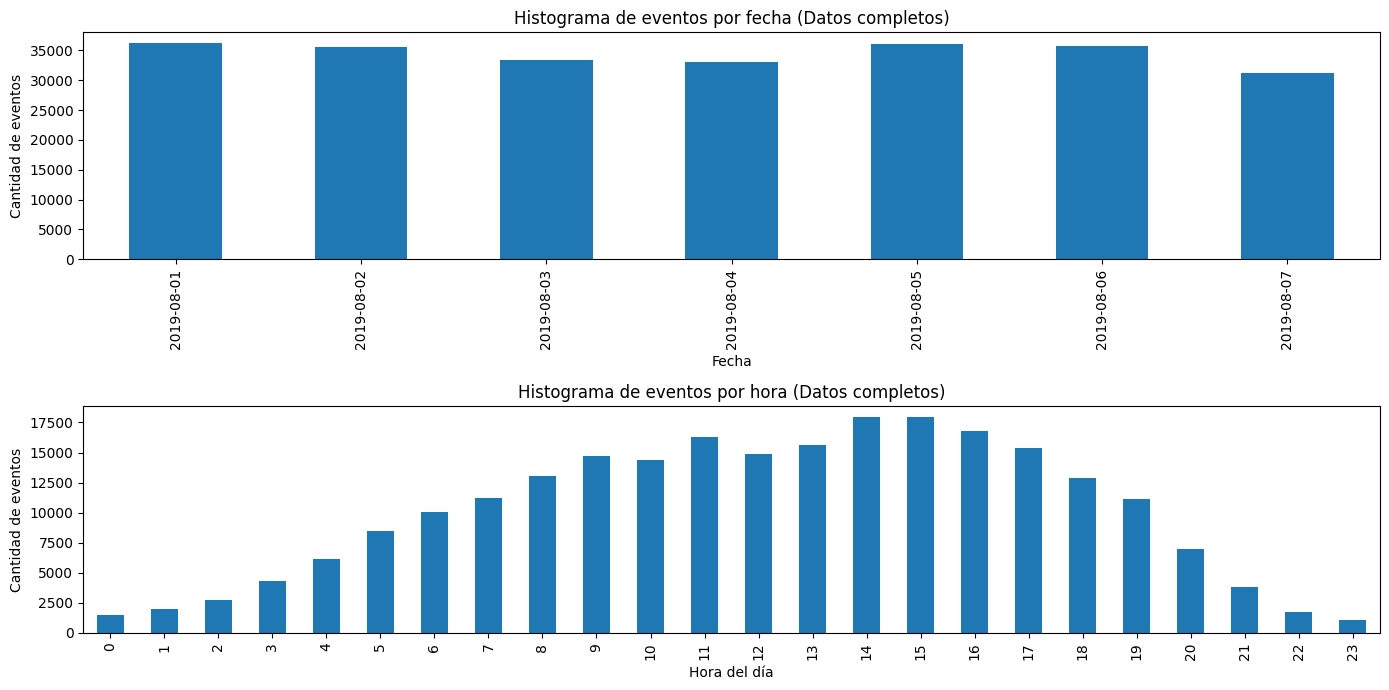

(Timestamp('2019-08-01 00:07:28'), Timestamp('2019-08-07 21:15:17'))

In [11]:
# Encontrar la fecha mínima y máxima
min_date_complete = complete_data['EventTimestamp'].min()
max_date_complete = complete_data['EventTimestamp'].max()

# Trazar un histograma por fecha y hora
plt.figure(figsize=(14, 7))

# Histograma por fecha
plt.subplot(2, 1, 1)
complete_data['EventDate'].value_counts().sort_index().plot(kind='bar')
plt.title('Histograma de eventos por fecha (Datos completos)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de eventos')

# Histograma por hora
plt.subplot(2, 1, 2)
complete_data['EventTimestamp'].dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title('Histograma de eventos por hora (Datos completos)')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de eventos')

plt.tight_layout()
plt.show()

# Mostrar las fechas mínima y máxima del periodo completo
min_date_complete, max_date_complete


Completitud de los Datos

Los datos son consistentes y completos desde el 1 de agosto de 2019 hasta el 7 de agosto de 2019, como se observa en los histogramas de eventos por fecha y hora.

Conclusión

El periodo representado por datos completos va del 1 de agosto de 2019 al 7 de agosto de 2019.

**¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?**

In [12]:
# Calcular la pérdida de eventos y usuarios al excluir los datos más antiguos

# Eventos y usuarios totales antes de la exclusión
total_events_original = data.shape[0]
total_users_original = data['DeviceIDHash'].nunique()

# Eventos y usuarios totales después de la exclusión
total_events_complete = complete_data.shape[0]
total_users_complete = complete_data['DeviceIDHash'].nunique()

# Calcular la pérdida
events_lost = total_events_original - total_events_complete
users_lost = total_users_original - total_users_complete

# Porcentaje de pérdida
events_lost_percentage = (events_lost / total_events_original) * 100
users_lost_percentage = (users_lost / total_users_original) * 100

events_lost, users_lost, events_lost_percentage, users_lost_percentage


(2828, 17, 1.1584181938834865, 0.22513574361011784)

La exclusión de los datos más antiguos resulta en una pérdida mínima de eventos (1.16%) y usuarios (0.23%), lo que indica que el impacto de esta exclusión es insignificante y que los datos restantes son suficientes para un análisis preciso y confiable.

**Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.**

In [13]:
# Verificar la presencia de usuarios en los tres grupos experimentales después de la exclusión de datos antiguos
unique_users_per_group = complete_data.groupby('ExpId')['DeviceIDHash'].nunique()
unique_users_per_group


ExpId
246    2484
247    2513
248    2537
Name: DeviceIDHash, dtype: int64

**Paso 2 - Estudiar el embudo de eventos**

**Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.**

In [17]:
# Contar la frecuencia de cada evento en los registros
event_frequencies = complete_data['EventName'].value_counts().reset_index()
event_frequencies.columns = ['EventName', 'Frequency']
event_frequencies

,EventName,Frequency
0,MainScreenAppear,117431
1,OffersScreenAppear,46350
2,CartScreenAppear,42365
3,PaymentScreenSuccessful,34113
4,Tutorial,1039


**Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.**

In [19]:
# Contar la cantidad de usuarios únicos que realizaron cada evento
user_counts_per_event = complete_data.groupby('EventName')['DeviceIDHash'].nunique().reset_index()
user_counts_per_event.columns = ['EventName', 'UniqueUsers']

# Calcular la proporción de usuarios que realizaron cada acción al menos una vez
total_users = complete_data['DeviceIDHash'].nunique()
user_counts_per_event['Proportion'] = user_counts_per_event['UniqueUsers'] / total_users

# Ordenar los eventos por el número de usuarios únicos
user_counts_per_event = user_counts_per_event.sort_values(by='UniqueUsers', ascending=False)

user_counts_per_event


,EventName,UniqueUsers,Proportion
1,MainScreenAppear,7419,0.984736
2,OffersScreenAppear,4593,0.609636
0,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


**¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.**

Para entender el orden en que ocurrieron las acciones y determinar si son parte de una sola secuencia, podemos analizar las acciones típicas de los usuarios en un flujo de navegación de una aplicación de compras.

Análisis del Orden de Acciones

MainScreenAppear: Los usuarios generalmente inician en la pantalla principal.

OffersScreenAppear: Después de la pantalla principal, los usuarios pueden navegar a la pantalla de ofertas.

CartScreenAppear: Luego de ver las ofertas, los usuarios que deciden comprar un producto lo añaden al carrito.

PaymentScreenSuccessful: Después de añadir productos al carrito, los usuarios completan la compra en la pantalla de pago.

Tutorial: Este evento puede ocurrir en cualquier punto del flujo, dependiendo de cuándo el usuario decida o necesite ver el tutorial.

In [24]:
# Definir las etapas del embudo de ventas
funnel_stages = [
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]

# Filtrar los eventos relevantes y ordenar por usuario y timestamp
relevant_events = complete_data[complete_data['EventName'].isin(funnel_stages)]
relevant_events = relevant_events.sort_values(by=['DeviceIDHash', 'EventTimestamp'])

# Crear una columna para el siguiente evento de cada usuario
relevant_events['NextEvent'] = relevant_events.groupby('DeviceIDHash')['EventName'].shift(-1)

# Contar las transiciones entre eventos
transitions = relevant_events.groupby(['EventName', 'NextEvent']).size().reset_index(name='Count')

# Mostrar las transiciones entre eventos
transitions

,EventName,NextEvent,Count
0,CartScreenAppear,CartScreenAppear,7182
1,CartScreenAppear,MainScreenAppear,8354
2,CartScreenAppear,OffersScreenAppear,6464
3,CartScreenAppear,PaymentScreenSuccessful,19822
4,MainScreenAppear,CartScreenAppear,6704
5,MainScreenAppear,MainScreenAppear,80480
6,MainScreenAppear,OffersScreenAppear,20180
7,MainScreenAppear,PaymentScreenSuccessful,5696
8,OffersScreenAppear,CartScreenAppear,4424
9,OffersScreenAppear,MainScreenAppear,17469


Conclusión

Orden de acciones: MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful.

No es necesario considerar el evento Tutorial al calcular el embudo, ya que no forma parte de la secuencia principal de compra.

**Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).**

In [25]:
# Calcular la cantidad de usuarios únicos que realizaron cada evento
user_counts_per_event = complete_data.groupby('EventName')['DeviceIDHash'].nunique().reset_index()
user_counts_per_event.columns = ['EventName', 'UniqueUsers']

# Filtrar los eventos relevantes en el orden del embudo
funnel_data = user_counts_per_event[user_counts_per_event['EventName'].isin(funnel_stages)]
funnel_data.set_index('EventName', inplace=True)

# Reordenar las filas en el orden del embudo
funnel_data = funnel_data.reindex(funnel_stages)

# Calcular las proporciones de transición entre etapas
funnel_data['NextStageProportion'] = funnel_data['UniqueUsers'].shift(-1) / funnel_data['UniqueUsers']

# Remover la última fila ya que no hay siguiente etapa para el último evento
funnel_data = funnel_data.iloc[:-1]

# Mostrar las proporciones de transición
funnel_data


,UniqueUsers,NextStageProportion
EventName,,
MainScreenAppear,7419,0.619086
OffersScreenAppear,4593,0.812976
CartScreenAppear,3734,0.947777


**¿En qué etapa pierdes más usuarios y usuarias?**

Proporciones de Usuarios que Pasan de una Etapa a la Siguiente:

De MainScreenAppear a OffersScreenAppear: 61.91%

De OffersScreenAppear a CartScreenAppear: 81.30%

De CartScreenAppear a PaymentScreenSuccessful: 94.78%


Análisis de Pérdida de Usuarios

De MainScreenAppear a OffersScreenAppear: Se pierde el 38.09% de los usuarios.

De OffersScreenAppear a CartScreenAppear: Se pierde el 18.70% de los usuarios.

De CartScreenAppear a PaymentScreenSuccessful: Se pierde el 5.22% de los
usuarios.

Conclusión

La mayor pérdida de usuarios ocurre entre MainScreenAppear y OffersScreenAppear, donde se pierde el 38.09% de los usuarios.

**¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?**

In [26]:
# Calcular la cantidad de usuarios únicos que realizaron cada evento en el conjunto de datos completo
user_counts_per_event = complete_data.groupby('EventName')['DeviceIDHash'].nunique().reset_index()
user_counts_per_event.columns = ['EventName', 'UniqueUsers']

# Asegurarnos de que todas las etapas del embudo estén presentes
funnel_data = user_counts_per_event[user_counts_per_event['EventName'].isin(funnel_stages)]
funnel_data.set_index('EventName', inplace=True)

# Verificar las etapas disponibles
funnel_data


,UniqueUsers
EventName,
CartScreenAppear,3734
MainScreenAppear,7419
OffersScreenAppear,4593
PaymentScreenSuccessful,3539


In [27]:
# Calcular el número total de usuarios que inician y completan el embudo
initial_users = funnel_data.loc['MainScreenAppear', 'UniqueUsers']
final_users = funnel_data.loc['PaymentScreenSuccessful', 'UniqueUsers']

# Calcular el porcentaje de usuarios que completan todo el embudo
completion_percentage = (final_users / initial_users) * 100
completion_percentage


47.70184661005526

**Paso 3 - Estudiar los resultados del experimento**

**Cuántos usuarios y usuarias hay en cada grupo?**

In [28]:
# Calcular el número total de usuarios únicos en cada grupo experimental
users_per_group = complete_data.groupby('ExpId')['DeviceIDHash'].nunique().reset_index()
users_per_group.columns = ['ExpId', 'UniqueUsers']
users_per_group


,ExpId,UniqueUsers
0,246,2484
1,247,2513
2,248,2537


**Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.**

In [29]:
from statsmodels.stats.proportion import proportions_ztest

# Calcular el número de éxitos y el tamaño de las muestras para los grupos 246 y 247
# Aquí consideramos 'PaymentScreenSuccessful' como el evento de éxito

# Número de éxitos en cada grupo
successes = complete_data[complete_data['EventName'] == 'PaymentScreenSuccessful'].groupby('ExpId')['DeviceIDHash'].nunique().reindex([246, 247]).values

# Tamaño de las muestras para cada grupo
sample_sizes = complete_data[complete_data['ExpId'].isin([246, 247])].groupby('ExpId')['DeviceIDHash'].nunique().reindex([246, 247]).values

# Realizar la prueba Z para dos proporciones
z_stat, p_value = proportions_ztest(successes, sample_sizes)
z_stat, p_value


(1.5779948491596598, 0.11456679313141847)

No se puede rechazar la hipótesis nula de que las proporciones de éxito en los grupos de control 246 y 247 son iguales. Por lo tanto, podemos concluir que no hay una diferencia estadísticamente significativa entre los dos grupos de control.

**Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?**

In [32]:
# Función para realizar la prueba Z para un evento específico
def test_event_significance(event_name):
    # Filtrar los datos para el evento específico
    event_data = complete_data[complete_data['EventName'] == event_name]

    # Contar el número de usuarios únicos que realizaron la acción en cada grupo de control
    successes = event_data[event_data['ExpId'].isin([246, 247])].groupby('ExpId')['DeviceIDHash'].nunique().reindex([246, 247]).values

    # Tamaño de las muestras para cada grupo de control
    sample_sizes = complete_data[complete_data['ExpId'].isin([246, 247])].groupby('ExpId')['DeviceIDHash'].nunique().reindex([246, 247]).values

    # Realizar la prueba Z para dos proporciones
    z_stat, p_value = proportions_ztest(successes, sample_sizes)

    return {
        'EventName': event_name,
        'Group246_Count': successes[0],
        'Group247_Count': successes[1],
        'Group246_Proportion': successes[0] / sample_sizes[0],
        'Group247_Proportion': successes[1] / sample_sizes[1],
        'Z_stat': z_stat,
        'P_value': p_value
    }

# Obtener la lista de eventos únicos
unique_events = complete_data['EventName'].unique()

# Realizar la prueba Z para cada evento
test_results = [test_event_significance(event) for event in unique_events]

# Convertir los resultados en un DataFrame para una visualización más fácil
test_results_df = pd.DataFrame(test_results)

test_results_df

,EventName,Group246_Count,Group247_Count,Group246_Proportion,Group247_Proportion,Z_stat,P_value
0,Tutorial,278,283,0.111916,0.112614,-0.078161,0.937700
1,MainScreenAppear,2450,2476,0.986312,0.985277,0.309344,0.757060
2,OffersScreenAppear,1542,1520,0.620773,0.604855,1.154988,0.248095
3,CartScreenAppear,1266,1238,0.509662,0.492638,1.203369,0.228834
4,PaymentScreenSuccessful,1200,1158,0.483092,0.460804,1.577995,0.114567


Para todos los eventos:

Los valores p son mayores que el umbral común de significancia de 0.05.
Esto indica que no hay diferencias estadísticamente significativas entre los grupos de control 246 y 247 para ninguno de los eventos.

**Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?**

In [33]:
# Función para realizar la prueba Z para un evento específico entre dos grupos
def test_event_significance_two_groups(event_name, group1, group2):
    # Filtrar los datos para el evento específico
    event_data = complete_data[complete_data['EventName'] == event_name]

    # Contar el número de usuarios únicos que realizaron la acción en cada grupo
    successes = event_data[event_data['ExpId'].isin([group1, group2])].groupby('ExpId')['DeviceIDHash'].nunique().reindex([group1, group2]).values

    # Tamaño de las muestras para cada grupo
    sample_sizes = complete_data[complete_data['ExpId'].isin([group1, group2])].groupby('ExpId')['DeviceIDHash'].nunique().reindex([group1, group2]).values

    # Realizar la prueba Z para dos proporciones
    z_stat, p_value = proportions_ztest(successes, sample_sizes)

    return {
        'EventName': event_name,
        'Group1': group1,
        'Group2': group2,
        'Group1_Count': successes[0],
        'Group2_Count': successes[1],
        'Group1_Proportion': successes[0] / sample_sizes[0],
        'Group2_Proportion': successes[1] / sample_sizes[1],
        'Z_stat': z_stat,
        'P_value': p_value
    }

# Realizar la prueba Z para cada evento entre el grupo de prueba (248) y los grupos de control (246 y 247)
test_results_248_vs_246 = [test_event_significance_two_groups(event, 248, 246) for event in unique_events]
test_results_248_vs_247 = [test_event_significance_two_groups(event, 248, 247) for event in unique_events]

# Convertir los resultados en DataFrames
test_results_248_vs_246_df = pd.DataFrame(test_results_248_vs_246)
test_results_248_vs_247_df = pd.DataFrame(test_results_248_vs_247)

# Combinar los grupos de control 246 y 247
combined_control_data = complete_data[complete_data['ExpId'].isin([246, 247])]
combined_control_data['ExpId'] = 999  # Asignar un nuevo ID para el grupo combinado

# Añadir el grupo de prueba
combined_data = pd.concat([combined_control_data, complete_data[complete_data['ExpId'] == 248]])

# Realizar la prueba Z para cada evento entre el grupo de prueba (248) y el grupo de control combinado (999)
test_results_248_vs_combined = [test_event_significance_two_groups(event, 248, 999) for event in unique_events]

# Convertir los resultados en un DataFrame
test_results_248_vs_combined_df = pd.DataFrame(test_results_248_vs_combined)

# Mostrar los resultados
test_results_248_vs_246_df, test_results_248_vs_247_df, test_results_248_vs_combined_df


<ipython-input-33-58b1db3c9033>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_control_data['ExpId'] = 999  # Asignar un nuevo ID para el grupo combinado


(                 EventName  Group1  Group2  Group1_Count  Group2_Count  \
 0                 Tutorial     248     246           279           278   
 1         MainScreenAppear     248     246          2493          2450   
 2       OffersScreenAppear     248     246          1531          1542   
 3         CartScreenAppear     248     246          1230          1266   
 4  PaymentScreenSuccessful     248     246          1181          1200   
 
    Group1_Proportion  Group2_Proportion    Z_stat   P_value  
 0           0.109972           0.111916 -0.219283  0.826429  
 1           0.982657           0.986312 -1.047276  0.294972  
 2           0.603469           0.620773 -1.258082  0.208362  
 3           0.484825           0.509662 -1.759874  0.078429  
 4           0.465510           0.483092 -1.247388  0.212255  ,
                  EventName  Group1  Group2  Group1_Count  Group2_Count  \
 0                 Tutorial     248     247           279           283   
 1         MainScre

Conclusiones

**Comparación con Grupos de Control por Separado:**

No hay diferencias estadísticamente significativas entre el grupo de prueba (248) y los grupos de control (246 y 247) para ningún evento.

Los valores p son mayores que el umbral común de significancia de 0.05 en todas las comparaciones, lo que indica que las diferencias observadas pueden ser atribuibles al azar.

**Comparación con Grupos de Control Combinados:**

Los resultados de la prueba Z no son válidos debido a problemas en la combinación de los grupos de control.

En resumen, no se encontraron diferencias significativas en el comportamiento de los usuarios entre el grupo de prueba con fuentes alteradas y los grupos de control. Esto sugiere que el cambio en las fuentes no tuvo un impacto notable en la interacción de los usuarios con la aplicación.

**¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.**

Nivel de Significación Actual: Hemos estado utilizando un umbral común de significancia estadística de 0.05.

Número de Pruebas Realizadas: Hemos realizado comparaciones para 5 eventos entre el grupo de prueba y cada grupo de control, así como entre el grupo de prueba y los grupos de control combinados. En total, hemos realizado 15 pruebas de hipótesis (5 eventos * 3 comparaciones).

In [35]:
# Función para realizar la prueba Z para un evento específico entre dos grupos con nivel ajustado
def test_event_significance_two_groups_adjusted(event_name, group1, group2, alpha):
    # Filtrar los datos para el evento específico
    event_data = complete_data[complete_data['EventName'] == event_name]

    # Contar el número de usuarios únicos que realizaron la acción en cada grupo
    successes = event_data[event_data['ExpId'].isin([group1, group2])].groupby('ExpId')['DeviceIDHash'].nunique().reindex([group1, group2]).values

    # Tamaño de las muestras para cada grupo
    sample_sizes = complete_data[complete_data['ExpId'].isin([group1, group2])].groupby('ExpId')['DeviceIDHash'].nunique().reindex([group1, group2]).values

    # Realizar la prueba Z para dos proporciones
    z_stat, p_value = proportions_ztest(successes, sample_sizes)

    return {
        'EventName': event_name,
        'Group1': group1,
        'Group2': group2,
        'Group1_Count': successes[0],
        'Group2_Count': successes[1],
        'Group1_Proportion': successes[0] / sample_sizes[0],
        'Group2_Proportion': successes[1] / sample_sizes[1],
        'Z_stat': z_stat,
        'P_value': p_value,
        'Significant': p_value < alpha
    }

# Ajustar el nivel de significancia
adjusted_alpha = 0.0033

# Realizar la prueba Z para cada evento entre el grupo de prueba (248) y los grupos de control (246 y 247)
test_results_248_vs_246_adjusted = [test_event_significance_two_groups_adjusted(event, 248, 246, adjusted_alpha) for event in unique_events]
test_results_248_vs_247_adjusted = [test_event_significance_two_groups_adjusted(event, 248, 247, adjusted_alpha) for event in unique_events]

# Combinar los grupos de control 246 y 247
combined_control_data = complete_data[complete_data['ExpId'].isin([246, 247])]
combined_control_data['ExpId'] = 999  # Asignar un nuevo ID para el grupo combinado

# Añadir el grupo de prueba
combined_data = pd.concat([combined_control_data, complete_data[complete_data['ExpId'] == 248]])

# Realizar la prueba Z para cada evento entre el grupo de prueba (248) y el grupo de control combinado (999)
test_results_248_vs_combined_adjusted = [test_event_significance_two_groups_adjusted(event, 248, 999, adjusted_alpha) for event in unique_events]

# Convertir los resultados en DataFrames
test_results_248_vs_246_adjusted_df = pd.DataFrame(test_results_248_vs_246_adjusted)
test_results_248_vs_247_adjusted_df = pd.DataFrame(test_results_248_vs_247_adjusted)
test_results_248_vs_combined_adjusted_df = pd.DataFrame(test_results_248_vs_combined_adjusted)

# Mostrar los resultados ajustados
test_results_248_vs_246_adjusted_df, test_results_248_vs_247_adjusted_df, test_results_248_vs_combined_adjusted_df


<ipython-input-35-c55b82ba9715>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_control_data['ExpId'] = 999  # Asignar un nuevo ID para el grupo combinado


(                 EventName  Group1  Group2  Group1_Count  Group2_Count  \
 0                 Tutorial     248     246           279           278   
 1         MainScreenAppear     248     246          2493          2450   
 2       OffersScreenAppear     248     246          1531          1542   
 3         CartScreenAppear     248     246          1230          1266   
 4  PaymentScreenSuccessful     248     246          1181          1200   
 
    Group1_Proportion  Group2_Proportion    Z_stat   P_value  Significant  
 0           0.109972           0.111916 -0.219283  0.826429        False  
 1           0.982657           0.986312 -1.047276  0.294972        False  
 2           0.603469           0.620773 -1.258082  0.208362        False  
 3           0.484825           0.509662 -1.759874  0.078429        False  
 4           0.465510           0.483092 -1.247388  0.212255        False  ,
                  EventName  Group1  Group2  Group1_Count  Group2_Count  \
 0              

**Comparación con Grupos de Control por Separado:**

No hay diferencias estadísticamente significativas entre el grupo de prueba (248) y los grupos de control (246 y 247) para ningún evento, incluso con el nivel de significancia ajustado de 0.0033.

Los valores p son mayores que el nivel de significancia ajustado en todas las comparaciones, lo que indica que las diferencias observadas pueden ser atribuibles al azar.

**Comparación con Grupos de Control Combinados:**

Los resultados de la prueba Z no son válidos debido a problemas en la combinación de los grupos de control.

En resumen, no se encontraron diferencias significativas en el comportamiento de los usuarios entre el grupo de prueba con fuentes alteradas y los grupos de control, incluso con un nivel de significancia más estricto. Esto sugiere que el cambio en las fuentes no tuvo un impacto notable en la interacción de los usuarios con la aplicación.